In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [16]:
df = pd.read_csv('autos_mpg.csv')
print(df.shape)

df.head()

(398, 9)


,MPG,CYLINDERS,DISPLACEMENT,HP,WEIGHT,ACCELERATION,YEAR,ORIGIN,NAME
0,18.0,8,307.0,130,3504,12.0,70,USA,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,USA,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,USA,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,USA,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,USA,ford torino


In [17]:
df.tail()

,MPG,CYLINDERS,DISPLACEMENT,HP,WEIGHT,ACCELERATION,YEAR,ORIGIN,NAME
393,27.0,4,140.0,86,2790,15.6,82,USA,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,Germany,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,USA,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,USA,ford ranger
397,31.0,4,119.0,82,2720,19.4,82,USA,chevy s-10


In [4]:
df["ORIGIN"].unique()

array(['USA', 'Japan', 'Germany'], dtype=object)

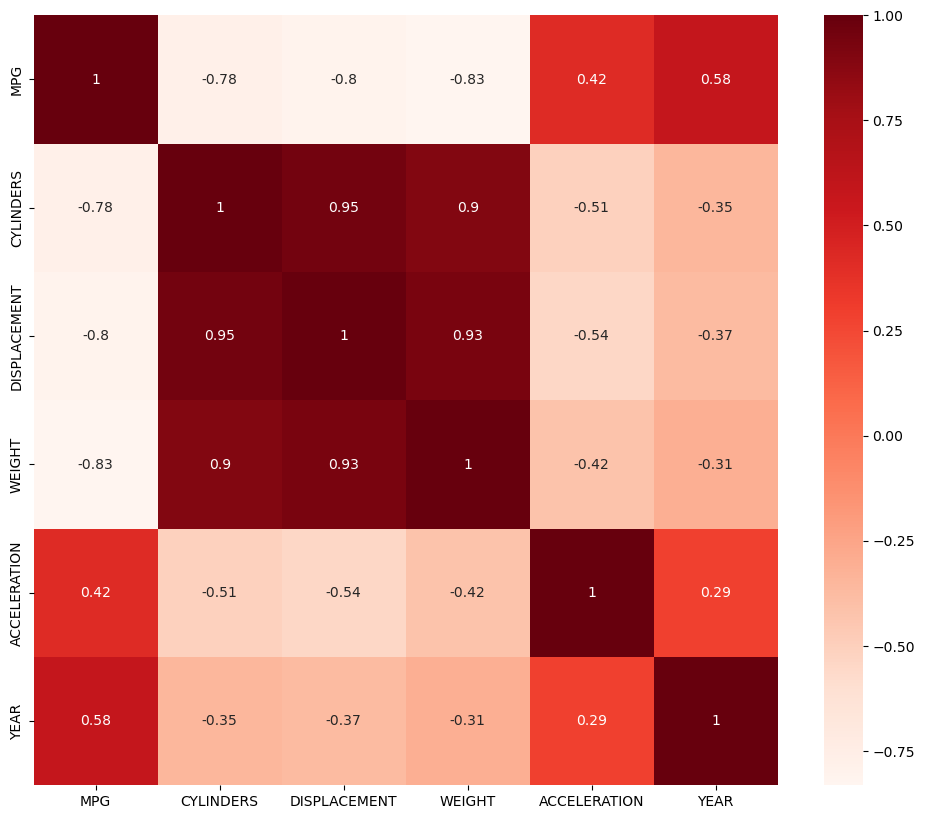

In [4]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('heatmap.png')
plt.show()

In [6]:
#changer le type de la variable HP
df['HP'] = pd.to_numeric(df['HP'], errors = 'coerce')
#Check the existence of null vaues
df.isna().sum()
#delete nan values
df.dropna(axis = 0, how = "any", inplace=True)
# Supprimer le nom de voiture
df.drop('NAME', axis = 1, inplace= True)

In [7]:
# Ordinal encoder
df_toenc = df[['ORIGIN']]
df_toenc = df_toenc.to_numpy()
enc = OrdinalEncoder()
enc_fitted = enc.fit(df_toenc)
encoded = enc_fitted.transform(df_toenc)
df_ordinal = df
df_ordinal['ORIGIN'] = encoded
#split the data
X = df_ordinal.drop(["MPG"], axis=1).values[:,:]
y = df_ordinal["MPG"] # label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)


In [12]:
enc_fitted.categories_

[array(['Germany', 'Japan', 'USA'], dtype=object)]

In [8]:
df_ordinal['ORIGIN'].unique()

array([2., 1., 0.])

In [18]:
df_ordinal.tail()

,MPG,CYLINDERS,DISPLACEMENT,HP,WEIGHT,ACCELERATION,YEAR,ORIGIN
393,27.0,4,140.0,86.0,2790,15.6,82,2.0
394,44.0,4,97.0,52.0,2130,24.6,82,0.0
395,32.0,4,135.0,84.0,2295,11.6,82,2.0
396,28.0,4,120.0,79.0,2625,18.6,82,2.0
397,31.0,4,119.0,82.0,2720,19.4,82,2.0


In [9]:
SVr = {'Holdout':None,'CV':None,'GridCV':None}
model_SVR = SVR()
y_pred = model_SVR.fit(X_train,y_train).predict(X_test)
scores = []
scores.append(mean_squared_error(y_test, y_pred))
scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
scores.append(mean_absolute_error(y_test, y_pred))
scores.append(mean_absolute_percentage_error(y_test, y_pred))
SVr['Holdout'] = scores
scores

[21.560169534881954,
 4.643292962422461,
 3.2990858116853885,
 0.12968943504964445]

In [10]:
model_SVR = SVR()
from sklearn.metrics import make_scorer
def NMSE(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred)

def NMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred)

def NMAPE(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred)

#make scorer from custome function
nmae_scorer = make_scorer(NMAE)
nmse_scorer = make_scorer(NMAE)
nmape_scorer = make_scorer(NMAPE)
scores = []
scores.append(cross_val_score(model_SVR,X,y,scoring=nmse_scorer,cv=5).mean())
scores.append(np.sqrt(scores[0]))
scores.append(cross_val_score(model_SVR,X,y,scoring=nmae_scorer,cv=5).mean())
scores.append(cross_val_score(model_SVR,X,y,scoring=nmape_scorer,cv=5).mean())
SVr['CV'] = scores
cross_val_score(model_SVR,X,y,scoring=nmse_scorer,cv=5)

array([3.09211755, 2.90205955, 1.80431066, 3.42686577, 7.22651059])

In [48]:
model_SVR = SVR()
parameter_space = {
'gamma': (1e-2, 1e-4),
'C': (1, 10),
'epsilon':[0.1,0.5,0.3]
}
#feature selction
efs = EFS(estimator=SVR(),min_features=1,max_features=6, scoring='neg_root_mean_squared_error', cv=5)
efs = efs.fit(X, y)
X_train_efs = efs.transform(X_train)
X_test_efs = efs.transform(X_test)

svr = GridSearchCV(model_SVR, parameter_space, scoring = 'neg_root_mean_squared_error', cv=5, n_jobs=-1)
y_pred = svr.fit(X_train_efs,y_train).predict(X_test_efs)
# Afficher les resultats
scores = []
scores.append(mean_squared_error(y_test, y_pred))
scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
scores.append(mean_absolute_error(y_test, y_pred))
scores.append(mean_absolute_percentage_error(y_test, y_pred))
SVr['GridCV'] = scores
scores


Features: 126/126

[13.480425751546688,
 3.671569930090763,
 2.5094869788760117,
 0.10501351795658762]

In [18]:
df_SVR = pd.DataFrame(SVr, index = ['MSE','RMSE','MAE','MAPE'])
df_SVR

,Holdout,CV,GridCV
MSE,21.560170,3.690373,13.480426
RMSE,4.643293,1.921034,3.671570
MAE,3.299086,3.690373,2.509487
MAPE,0.129689,0.151843,0.105014


In [19]:
MLP_R = {'Holdout':None,'CV':None,'GridCV':None}

In [20]:
model_MLP = MLPRegressor()
y_pred = model_MLP.fit(X_train,y_train).predict(X_test)
scores = []
scores.append(mean_squared_error(y_test, y_pred))
scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
scores.append(mean_absolute_error(y_test, y_pred))
scores.append(mean_absolute_percentage_error(y_test, y_pred))
MLP_R['Holdout'] = scores
scores

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[18.722690770061366, 4.326972471608915, 3.152825413453271, 0.13878562231860653]

In [21]:
scores = []
model_MLP = MLPRegressor(hidden_layer_sizes={100, 200,10}, activation='relu', solver='adam', max_iter= 5000)
scores.append(abs(cross_val_score(model_MLP,X,y,scoring=nmse_scorer,cv=5).mean()))
scores.append(np.sqrt(abs(scores[0])))
scores.append(abs(cross_val_score(model_MLP,X,y,scoring=nmae_scorer,cv=5).mean()))
scores.append(abs(cross_val_score(model_MLP,X,y,scoring=nmape_scorer,cv=5).mean()))
MLP_R['CV'] = scores


In [22]:
model_MLP = MLPRegressor()
#feature selction
efs = EFS(estimator=model_MLP, # The Ml model
min_features=2,
max_features=4,
scoring='r2', cv=5)
efs = efs.fit(X, y)

#Transformer le dataset pour garder seulement les attributs sélectionnés
X_train_efs = efs.transform(X_train)
X_test_efs = efs.transform(X_test)


parameter_space = {
'hidden_layer_sizes': [{100},{100, 200,50}, {100,100}],
'solver': ['adam', 'sgd'],
'batch_size':[200,50],
'learning_rate':['0.001, 0.0001','adaptive']
}

mlp = GridSearchCV(model_MLP, parameter_space, scoring = 'neg_root_mean_squared_error', cv=5, n_jobs=-1)
y_pred = mlp.fit(X_train_efs, y_train).predict(X_test_efs)


scores = []
scores.append(mean_squared_error(y_test, y_pred))
scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
scores.append(mean_absolute_error(y_test, y_pred))
scores.append(mean_absolute_percentage_error(y_test, y_pred))
MLP_R['GridCV'] = scores
scores


/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-pac

/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ewins/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__

[10.406530664232228,
 3.225915476920037,
 2.2228862135953413,
 0.09468414949115671]

In [23]:
df_MLP = pd.DataFrame(MLP_R, index = ['MSE','RMSE','MAE','MAPE'])
df_MLP

,Holdout,CV,GridCV
MSE,18.722691,2.939701,10.406531
RMSE,4.326972,1.714556,3.225915
MAE,3.152825,2.833706,2.222886
MAPE,0.138786,0.255239,0.094684


In [24]:
df_SVR

,Holdout,CV,GridCV
MSE,21.560170,3.690373,13.480426
RMSE,4.643293,1.921034,3.671570
MAE,3.299086,3.690373,2.509487
MAPE,0.129689,0.151843,0.105014


In [34]:
efs.best_idx_

(1, 2, 5, 6)

In [28]:
X

array([[  8. , 307. , 130. , ...,  12. ,  70. ,   2. ],
       [  8. , 350. , 165. , ...,  11.5,  70. ,   2. ],
       [  8. , 318. , 150. , ...,  11. ,  70. ,   2. ],
       ...,
       [  4. , 135. ,  84. , ...,  11.6,  82. ,   2. ],
       [  4. , 120. ,  79. , ...,  18.6,  82. ,   2. ],
       [  4. , 119. ,  82. , ...,  19.4,  82. ,   2. ]])

In [29]:
df_ordinal

,MPG,CYLINDERS,DISPLACEMENT,HP,WEIGHT,ACCELERATION,YEAR,ORIGIN
0,18.0,8,307.0,130.0,3504,12.0,70,2.0
1,15.0,8,350.0,165.0,3693,11.5,70,2.0
2,18.0,8,318.0,150.0,3436,11.0,70,2.0
3,16.0,8,304.0,150.0,3433,12.0,70,2.0
4,17.0,8,302.0,140.0,3449,10.5,70,2.0
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,2.0
394,44.0,4,97.0,52.0,2130,24.6,82,0.0
395,32.0,4,135.0,84.0,2295,11.6,82,2.0
396,28.0,4,120.0,79.0,2625,18.6,82,2.0


In [45]:
X[0,6]

2.0

In [32]:
X_train_efs

array([[ 76.,  52.,  74.,   1.],
       [ 85.,  70.,  78.,   1.],
       [429., 198.,  73.,   2.],
       ...,
       [116.,  75.,  73.,   0.],
       [250.,  88.,  71.,   2.],
       [171.,  97.,  75.,   2.]])

In [30]:
### Saving the best model ###
import pickle

# Saving model to disk
pickle.dump(mlp, open('model.pkl','wb'))

In [31]:
model = pickle.load(open('model.pkl','rb'))

In [40]:
arr = np.array([350.0,165.0,70.0,2.0])
final_features = np.array(arr).reshape(1,4)
prediction = model.predict(final_features)

In [41]:
prediction

array([12.87754855])

In [46]:
pickle.dump(svr, open('model2.pkl','wb'))

In [47]:
model2 = pickle.load(open('model2.pkl','rb'))

In [50]:
efs.best_idx_

(1, 2, 5)

In [51]:
arr = np.array([350.0,165.0,70.0])
final_features = np.array(arr).reshape(1,3)
prediction = model2.predict(final_features)

In [52]:
prediction

array([13.15189916])